Author: Geoffrey Porto - https://www.linkedin.com/in/geoffreyporto/

In [ ]:
!pip install scikit-fuzzy

In [ ]:
import os
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

## Clases de Wrapper
Criamos uma classe wrapper que encapsule o sistema de controle difuso e implemente os métodos fit e predict de acordo com a API do scikit-learn.

O bloco try-except no método predict captura exceções ValueError e TypeError. Quando ocorre um erro durante a computação do sistema de controle difuso, um valor padrão de 0 é atribuído à previsão.

Podemos ajustar o valor padrão (0) de acordo com o seu caso específico. Além disso,podemos adicionar mensagens de log ou depuração para identificar os casos em que a computação do sistema de controle difuso está falhando.

Lembremos de revisar cuidadosamente a definição das variáveis de entrada, funções de pertinência e regras do seu sistema de controle difuso para garantir que estejam corretas e consistentes.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
class FuzzyControlSystemWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, control_system, idade_jovem_mean=20, idade_jovem_std=5,
                 idade_meia_idade_mean=40, idade_meia_idade_std=5):
        self.control_system = control_system
        self.sim = ctrl.ControlSystemSimulation(control_system)

        self.idade_jovem_mean = idade_jovem_mean
        self.idade_jovem_std = idade_jovem_std
        self.idade_meia_idade_mean = idade_meia_idade_mean
        self.idade_meia_idade_std = idade_meia_idade_std

        # Atualizar as funções de pertinência com os parâmetros fornecidos
        idade['Jovem'] = fuzz.gaussmf(idade.universe, self.idade_jovem_mean, self.idade_jovem_std)
        idade['Meia-idade'] = fuzz.gaussmf(idade.universe, self.idade_meia_idade_mean, self.idade_meia_idade_std)

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        previsoes = []
        for index, row in X.iterrows():
            self.sim.input['Idade'] = row['Idade']
            self.sim.input['Gravidade'] = row['Gravidade']
            self.sim.input['Renda'] = row['Renda']
            self.sim.input['Distancia'] = row['Distancia']
            self.sim.input['Frequencia'] = row['Frequencia']

            try:
                self.sim.compute()
                previsoes.append(self.sim.output['Risco'])
            except (ValueError, TypeError) as e:
                logger.error(f"Falha na computação do sistema de controle difuso para a linha {index}")
                logger.error(f"Valores de entrada: {row}")
                logger.error(f"Mensagem de erro: {str(e)}")
                previsoes.append(0)  # Valor padrão para falha na computação

        limite = 7
        previsoes_rotulos = ['Alto' if x >= limite else 'Baixo' for x in previsoes]
        return previsoes_rotulos


##Pré-processamento dos dados
Realize a normalização ou o escalonamento dos dados de entrada para garantir que estejam na mesma escala e evitar a dominância de certas variáveis.
Lide com outliers e valores discrepantes que possam afetar o desempenho do modelo.

In [ ]:
# Exemplo de normalização dos dados
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


Google Drive

**Dataset**

- Idade: A idade do paciente em anos
- Gravidade: A gravidade da condição do paciente (Leve, Moderada ou Grave).
- Renda: A renda mensal do paciente em reais.
- Distancia: A distância em quilômetros entre a residência do paciente e o hospital.
- Frequencia: A frequência do paciente às consultas agendadas, expressa em porcentagem.
- Risco: O risco de absenteísmo do paciente (Baixo, Medio ou Alto).

```
# Esto tiene formato de código
```



In [ ]:
from google.colab import drive
from google.colab import files  #biblioteca utilizada para carregar os dados para o google colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Carpeta base
base_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Health/'

#Base de dados completo
data_patients = base_path+'/Patients/'


os.listdir(data_patients)

['patients.csv', 'processed_patients.csv', 'patients_complex.gsheet']

In [ ]:
# Carregar dados de um arquivo CSV
#dados = pd.read_csv(data_patients+'patients.csv', delimiter=',', engine='pyarrow')
dados = pd.read_csv(data_patients+'patients.csv', delimiter=',', engine='pyarrow')
print(dados.head())
print(dados.columns)

   Idade Gravidade  Renda  Distancia  Frequencia  Risco
0     32      Leve  45000        5.2          95  Baixo
1     68     Grave  18000       12.8          60   Alto
2     25  Moderada  32000        2.1          85  Baixo
3     54  Moderada  28000        8.9          70  Medio
4     42      Leve  56000        3.7          90  Baixo
Index(['Idade', 'Gravidade', 'Renda', 'Distancia', 'Frequencia', 'Risco'], dtype='object')


In [ ]:

# Verificar se o DataFrame 'dados' está vazio
if dados.empty:
    print("O DataFrame 'dados' está vazio. Verifique o arquivo CSV.")
    exit()

# Verificar se as colunas necessárias estão presentes no DataFrame 'dados'
colunas_necessarias = ['Idade', 'Gravidade', 'Renda', 'Distancia', 'Frequencia', 'Risco']
if not all(col in dados.columns for col in colunas_necessarias):
    print("Uma ou mais colunas necessárias estão ausentes no DataFrame 'dados'.")
    exit()

# Dividir os dados em conjuntos de treinamento e teste
X = dados[['Idade', 'Gravidade', 'Renda', 'Distancia', 'Frequencia']]
y = dados['Risco']
print(X.shape)
print(y.shape)
print(X.head())
print(y.head())

(20, 5)
(20,)
   Idade Gravidade  Renda  Distancia  Frequencia
0     32      Leve  45000        5.2          95
1     68     Grave  18000       12.8          60
2     25  Moderada  32000        2.1          85
3     54  Moderada  28000        8.9          70
4     42      Leve  56000        3.7          90
0    Baixo
1     Alto
2    Baixo
3    Medio
4    Baixo
Name: Risco, dtype: object


In [ ]:
print("Idade:", dados['Idade'])
print("Gravidade:", dados['Gravidade'])
print("Renda:", dados['Renda'])
print("Distancia:", dados['Distancia'])
print("Frequencia:", dados['Frequencia'])

Idade: 0     32
1     68
2     25
3     54
4     42
5     78
6     37
7     61
8     29
9     50
10    71
11    46
12    58
13    39
14    64
15    33
16    52
17    75
18    28
19    44
Name: Idade, dtype: int64
Gravidade: 0         Leve
1        Grave
2     Moderada
3     Moderada
4         Leve
5        Grave
6         Leve
7        Grave
8         Leve
9     Moderada
10       Grave
11        Leve
12    Moderada
13        Leve
14       Grave
15        Leve
16    Moderada
17       Grave
18        Leve
19    Moderada
Name: Gravidade, dtype: object
Renda: 0     45000
1     18000
2     32000
3     28000
4     56000
5     12000
6     62000
7     22000
8     39000
9     48000
10    16000
11    58000
12    31000
13    51000
14    20000
15    47000
16    36000
17    14000
18    40000
19    53000
Name: Renda, dtype: int64
Distancia: 0      5.2
1     12.8
2      2.1
3      8.9
4      3.7
5     15.6
6      6.4
7     10.3
8      1.8
9      7.1
10    13.5
11     4.9
12     9.6
13     2.5
14    1

In [ ]:

# Pré-processar os dados
dados = dados.dropna()  # Remover registros com valores ausentes
dados['Gravidade'] = dados['Gravidade'].map({'Leve': 1, 'Moderada': 2, 'Grave': 3})
dados['Distancia'] = dados['Distancia'] / dados['Distancia'].max()  # Normalizar a distância

# Definir variáveis de entrada e saída
idade = ctrl.Antecedent(np.arange(0, 101, 1), 'Idade')
gravidade = ctrl.Antecedent(np.arange(1, 4, 1), 'Gravidade')
renda = ctrl.Antecedent(np.arange(0, 100001, 1), 'Renda')
distancia = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Distancia')
frequencia = ctrl.Antecedent(np.arange(0, 101, 1), 'Frequencia')
risco = ctrl.Consequent(np.arange(0, 11, 1), 'Risco')

# Definir funções de pertinência difusas para cobrir melhor o espaço de entrada

# Ajustar as funções de pertinência
idade['Jovem'] = fuzz.trapmf(idade.universe, [0, 0, 25, 35])
idade['Meia-idade'] = fuzz.trapmf(idade.universe, [30, 40, 50, 60])
idade['Idoso'] = fuzz.trapmf(idade.universe, [55, 65, 100, 100])

gravidade['Leve'] = fuzz.trapmf(gravidade.universe, [1, 1, 1, 2])
gravidade['Moderada'] = fuzz.trapmf(gravidade.universe, [1, 2, 2, 3])
gravidade['Grave'] = fuzz.trapmf(gravidade.universe, [2, 3, 3, 3])

renda['Baixa'] = fuzz.trapmf(renda.universe, [0, 0, 20000, 30000])
renda['Media'] = fuzz.trapmf(renda.universe, [20000, 30000, 50000, 60000])
renda['Alta'] = fuzz.trapmf(renda.universe, [50000, 60000, 100000, 100000])

distancia['Perto'] = fuzz.trapmf(distancia.universe, [0, 0, 0.3, 0.5])
distancia['Media'] = fuzz.trapmf(distancia.universe, [0.3, 0.5, 0.7, 0.9])
distancia['Longe'] = fuzz.trapmf(distancia.universe, [0.7, 0.9, 1, 1])

frequencia['Boa'] = fuzz.trapmf(frequencia.universe, [70, 90, 100, 100])
frequencia['Regular'] = fuzz.trapmf(frequencia.universe, [30, 50, 70, 90])
frequencia['Ruim'] = fuzz.trapmf(frequencia.universe, [0, 0, 30, 50])

risco['Baixo'] = fuzz.trimf(risco.universe, [0, 0, 5])
risco['Medio'] = fuzz.trimf(risco.universe, [0, 5, 10])
risco['Alto'] = fuzz.trimf(risco.universe, [5, 10, 10])


In [ ]:
# Definir regras difusas
regra1 = ctrl.Rule(idade['Idoso'] & (gravidade['Grave'] | gravidade['Moderada']) & distancia['Longe'], risco['Alto'])
#regra1 = ctrl.Rule(idade['Idoso'] & gravidade['Grave'] & distancia['Longe'], risco['Alto'])
regra2 = ctrl.Rule(renda['Baixa'] & frequencia['Ruim'], risco['Alto'])
regra3 = ctrl.Rule(idade['Jovem'] & gravidade['Leve'] & distancia['Perto'], risco['Baixo'])
regra4 = ctrl.Rule(renda['Alta'] & frequencia['Boa'], risco['Baixo'])
regra5 = ctrl.Rule(idade['Meia-idade'] & gravidade['Moderada'] & distancia['Media'] & frequencia['Regular'], risco['Medio'])
regra6 = ctrl.Rule(idade['Jovem'] & gravidade['Leve'] & distancia['Longe'] & renda['Media'], risco['Medio'])
regra7 = ctrl.Rule(idade['Meia-idade'] & gravidade['Leve'] & distancia['Media'] & renda['Media'], risco['Medio'])
regra8 = ctrl.Rule(idade['Idoso'] & gravidade['Moderada'] & frequencia['Regular'], risco['Alto'])
regra9 = ctrl.Rule(idade['Jovem'] & gravidade['Moderada'] & frequencia['Boa'], risco['Medio'])


In [ ]:

sistema_controle = ctrl.ControlSystem()

# Verificar as regras do sistema de controle difuso
print(sistema_controle.rules)


# Verificar as regras do sistema de controle difuso
print(sistema_controle.rules)


sistema_controle.addrule(regra1)
print("Regra 1 adicionada com sucesso!")

sistema_controle.addrule(regra2)
print("Regra 2 adicionada com sucesso!")

sistema_controle.addrule(regra3)
print("Regra 3 adicionada com sucesso!")

sistema_controle.addrule(regra4)
print("Regra 4 adicionada com sucesso!")

#sistema_controle.addrule(regra5)
#print("Regra 5 adicionada com sucesso!")

Regra 1 adicionada com sucesso!
Regra 2 adicionada com sucesso!
Regra 3 adicionada com sucesso!
Regra 4 adicionada com sucesso!


In [ ]:
#print(simulacao.rules)

# Imprimir as regras
print("Regra 1:", regra1)
print("Regra 2:", regra2)
print("Regra 3:", regra3)
print("Regra 4:", regra4)
print("Regra 5:", regra5)
print("Regra 6:", regra6)
print("Regra 7:", regra7)
print("Regra 8:", regra8)
print("Regra 9:", regra9)

OrderedDict([('Jovem', Idade[Jovem]), ('Meia-idade', Idade[Meia-idade]), ('Idoso', Idade[Idoso])])
OrderedDict([('Leve', Gravidade[Leve]), ('Moderada', Gravidade[Moderada]), ('Grave', Gravidade[Grave])])
OrderedDict([('Perto', Distancia[Perto]), ('Media', Distancia[Media]), ('Longe', Distancia[Longe])])
OrderedDict([('Baixa', Renda[Baixa]), ('Media', Renda[Media]), ('Alta', Renda[Alta])])
OrderedDict([('Boa', Frequencia[Boa]), ('Regular', Frequencia[Regular]), ('Ruim', Frequencia[Ruim])])
OrderedDict([('Baixo', Risco[Baixo]), ('Medio', Risco[Medio]), ('Alto', Risco[Alto])])


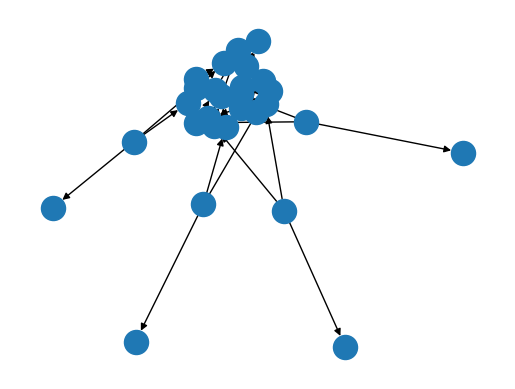

In [ ]:
# Criar o sistema de controle difuso com as regras
#sistema_controle = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6, regra7, regra8, regra9])

# Verificar se todas as variáveis estão definidas corretamente
print(idade.terms)
print(gravidade.terms)
print(distancia.terms)
print(renda.terms)
print(frequencia.terms)
print(risco.terms)

#sistema_controle = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5])

# sistema_controle.addrule(regra9)

# Criar a simulação do sistema difuso
simulacao = ctrl.ControlSystemSimulation(sistema_controle)
sistema_controle.view()

In [ ]:
print(simulacao.output)

OrderedDict()


In [ ]:

# Dividir os dados em conjuntos de treinamento e teste
X = dados[['Idade', 'Gravidade', 'Renda', 'Distancia', 'Frequencia']]
y = dados['Risco']
print(X.shape)
print(y.shape)

print(X.head())
print(y.head())



(20, 5)
(20,)
   Idade  Gravidade  Renda  Distancia  Frequencia
0     32          1  45000   0.333333          95
1     68          3  18000   0.820513          60
2     25          2  32000   0.134615          85
3     54          2  28000   0.570513          70
4     42          1  56000   0.237179          90
0    Baixo
1     Alto
2    Baixo
3    Medio
4    Baixo
Name: Risco, dtype: object


##Pré-processamento dos dados
Realize a normalização ou o escalonamento dos dados de entrada para garantir que estejam na mesma escala e evitar a dominância de certas variáveis.
Lide com outliers e valores discrepantes que possam afetar o desempenho do modelo.

In [ ]:
# Exemplo de normalização dos dados
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#Treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Seleção de variáveis:
Avalie a relevância de cada variável de entrada e considere remover variáveis que possam não contribuir significativamente para a previsão.
Utilize técnicas de seleção de variáveis, como a análise de correlação ou a importância das variáveis em modelos de aprendizado de máquina, para identificar as variáveis mais informativas.

In [ ]:
# Exemplo de seleção de variáveis usando a importância das variáveis em um modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importancias = rf.feature_importances_
# Selecionar as variáveis mais importantes com base em um limiar
limiar_importancia = 0.1
variaveis_selecionadas = X.columns[importancias >= limiar_importancia]

In [ ]:
variaveis_selecionadas

Index(['Idade', 'Renda', 'Distancia', 'Frequencia'], dtype='object')

# Validação cruzada:
Utilize a validação cruzada para avaliar o desempenho do modelo de forma mais robusta e evitar o overfitting.
A validação cruzada permite obter uma estimativa mais confiável da acurácia do modelo, treinando e testando em diferentes subconjuntos dos dados.

Lembremos de verificar se as variáveis de entrada (Idade, Gravidade, Renda, Distancia, Frequencia) estão definidas corretamente no seu sistema de controle difuso e se correspondem aos nomes usados na simulação.

Após fazer essas alterações, a validação cruzada deve ser executada sem erros e poderemos obter a acurácia média do seu modelo de sistema de controle difuso.

In [ ]:
from sklearn.model_selection import cross_val_score
# Criar uma instância do wrapper do sistema de controle difuso
fuzzy_system_wrapper = FuzzyControlSystemWrapper(sistema_controle)

# Realizar a validação cruzada
scores = cross_val_score(fuzzy_system_wrapper, X, y, cv=5, scoring='accuracy')
acuracia_media = scores.mean()
print(f"Acurácia média na validação cruzada: {acuracia_media:.2f}")


##Ajuste de hiperparâmetros:
Realize uma busca de hiperparâmetros para encontrar a melhor combinação de parâmetros para o seu modelo.
Utilize técnicas como a busca em grade (grid search) ou a busca aleatória (random search) para explorar diferentes configurações de hiperparâmetros.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'idade_jovem_mean': [10, 20, 30],
    'idade_jovem_std': [5, 10],
    'idade_meia_idade_mean': [40, 50],
    'idade_meia_idade_std': [5, 10],
    # Adicionar outros parâmetros
}

fuzzy_system_wrapper = FuzzyControlSystemWrapper(sistema_controle)
grid_search = GridSearchCV(fuzzy_system_wrapper, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
melhores_parametros = grid_search.best_params_

print("Melhores parâmetros encontrados:", melhores_parametros)

## Treinando o modelo difuso

In [ ]:
# Treinar o modelo difuso
previsoes_treino = []
for _, row in X_train.iterrows():
    simulacao.input['Idade'] = row['Idade']
    simulacao.input['Gravidade'] = row['Gravidade']
    simulacao.input['Renda'] = row['Renda']
    simulacao.input['Distancia'] = row['Distancia']
    simulacao.input['Frequencia'] = row['Frequencia']
    try:
        simulacao.compute()
        previsoes_treino.append(simulacao.output['Risco'])
    except ValueError:
        previsoes_treino.append(0)  # Atribuir um valor padrão quando a saída é vazia


In [ ]:
# Avaliar o modelo difuso no conjunto de teste
previsoes_teste = []
for _, row in X_test.iterrows():
    simulacao.input['Idade'] = row['Idade']
    simulacao.input['Gravidade'] = row['Gravidade']
    simulacao.input['Renda'] = row['Renda']
    simulacao.input['Distancia'] = row['Distancia']
    simulacao.input['Frequencia'] = row['Frequencia']
    try:
        simulacao.compute()
        previsoes_teste.append(simulacao.output['Risco'])
    except ValueError:
        previsoes_teste.append(0)  # Atribuir um valor padrão quando a saída é vazia



##Os rótulos discretos

 São um tipo de representação em que os valores são divididos em categorias ou classes distintas e não contínuas. Neste caso, os rótulos discretos são usados para converter as previsões numéricas contínuas em categorias discretas com base em um limite (threshold) específico.

##Utilidade e casos de uso dos rotulos
 Os rótulos discretos são úteis em várias situações:

- Interpretabilidade: Converter previsões numéricas em rótulos discretos pode tornar os resultados mais interpretáveis e compreensíveis para os usuários finais. Em vez de lidar com números contínuos, os rótulos discretos fornecem uma categorização mais clara e significativa.
- Tomada de decisão: Os rótulos discretos podem ser usados diretamente para tomar decisões com base nas previsões. Por exemplo, se o rótulo previsto for 'Alto', pode acionar uma ação específica, como enviar um alerta ou tomar uma medida preventiva.
- Avaliação do modelo: Os rótulos discretos permitem calcular métricas de avaliação, como acurácia, precisão, recall e F1-score, que são comumente usadas para avaliar o desempenho de modelos de classificação.



##Previsões numéricas


As previsões numéricas (previsoes_treino e previsoes_teste) são convertidas em rótulos discretos ('Alto' ou 'Baixo')
com base no valor do limite. Se a previsão numérica for maior ou igual ao limite, o rótulo atribuído será 'Alto';
caso contrário, será 'Baixo'.

Quanto ao ajuste do limite, ele depende do problema específico e dos requisitos do seu sistema.
O valor do limite determina a fronteira entre as classes discretas. Ajustar o limite permite controlar a sensibilidade
do modelo em relação à classificação das previsões.
Por exemplo, se você quiser que o modelo seja mais sensível em classificar as previsões como 'Alto',
pode diminuir o valor do limite. Isso fará com que mais previsões sejam classificadas como 'Alto'.
Por outro lado, se você quiser que o modelo seja mais restritivo ao classificar as previsões como 'Alto',
pode aumentar o valor do limite.

```python:

# Exemplo 1: Aumentar o limite para tornar o modelo mais restritivo
limite = 7
previsoes_treino_rotulos = ['Alto' if x >= limite else 'Baixo' for x in previsoes_treino]
previsoes_teste_rotulos = ['Alto' if x >= limite else 'Baixo' for x in previsoes_teste]

# Exemplo 3: Usar múltiplos limites para criar mais categorias discretas
limites = [3, 6, 8]
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']
previsoes_treino_rotulos = [labels[sum(x >= limite for limite in limites)] for x in previsoes_treino]
previsoes_teste_rotulos = [labels[sum(x >= limite for limite in limites)] for x in previsoes_teste]

```

In [ ]:

# Converter as previsões para rótulos discretos
limite = 7  # Ajustar conforme necessário
previsoes_treino_rotulos = ['Alto' if x >= limite else 'Baixo' for x in previsoes_treino]
previsoes_teste_rotulos = ['Alto' if x >= limite else 'Baixo' for x in previsoes_teste]



In [ ]:

# Calcular a acurácia do modelo difuso
acuracia_treino = accuracy_score(y_train, previsoes_treino_rotulos)
acuracia_teste = accuracy_score(y_test, previsoes_teste_rotulos)

print(f"Acurácia no conjunto de treinamento: {acuracia_treino:.2f}")
print(f"Acurácia no conjunto de teste: {acuracia_teste:.2f}")

Acurácia no conjunto de treinamento: 0.69
Acurácia no conjunto de teste: 1.00
